# Behavioral Cloning Project

In [19]:
import os
import csv
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D 
from keras.layers import Conv2D, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

## Image Loading, Processing and Augmentation
- Can use all three camera images

In [20]:
def load_images(img_path, fliped=False, all_cameras=False, correction=0.1):
    """
    Load and preprocess images, all images stored in memory
    :all_cameras: Load all 3 cameras 
    :correction: Steering angle correction factor (applies only with all_cameras=True)
    """
    images = []
    steering_angles = []

    start = time.time()

    with open(img_path) as csvfile: 
        reader = csv.reader(csvfile)
        for line in reader:
            steering_center = float(line[3])

            #if reader.line_num == 2940:
            #    break
            # create adjusted steering measurements for the side camera images
            steering_left = steering_center + correction
            steering_right = steering_center - correction

            ## read in and preprocess images from center camera
            img_center = cv2.imread(line[0])
            img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
            images.append(img_center)
            steering_angles.append(steering_center)
            #horizontal flip
            if fliped:
                images.append(cv2.flip(img_center,1))
                steering_angles.append(-steering_center)
            
            if all_cameras:
                ## read in and preprocess images from left camera
                img_left = cv2.imread(line[1])
                img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
                images.append(img_left)
                steering_angles.append(steering_left)
                ## read in and preprocess images from right camera
                img_right = cv2.imread(line[2])
                img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
                images.append(img_right)
                steering_angles.append(steering_right)

                if fliped:
                    #horizontal flip - left image
                    images.append(cv2.flip(img_left,1))
                    steering_angles.append(-steering_left)
                    #horizontal flip - right image
                    images.append(cv2.flip(img_right,1))
                    steering_angles.append(-steering_right)

    X_train = np.array(images)
    y_train = np.array(steering_angles)

    finish = time.time()

    print('Number of images: {}'.format(X_train.shape[0]))
    print('Total time to process images: {:.2f}[s]'.format(finish-start))
    
    return X_train, y_train

In [21]:
def plot_steering_command(data, xlim=(-1,1), name='figure.png'):
    """
    Plot steering angle command accross number of images
    :data: 1D array of steering angle commands
    :xlim: x axis limits
    """
    fig, axs = plt.subplots(1,2, figsize=(12, 4))
    axs[0].plot(data, 'orange')
    axs[0].set_title('Steering angle command vs # image')
    axs[0].set_xlabel('# image')
    axs[0].set_ylabel('Steering angle command')
    
    axs[1].hist(data, bins=20, facecolor='orange', edgecolor='k')
    axs[1].set_xlim([xlim[0],xlim[1]])
    axs[1].set_title('Steering angle command histogram')
    axs[1].set_xlabel('Steering angle command')
    axs[1].set_ylabel('Counts')

    axs[0].grid(); axs[1].grid()
    
    plt.savefig('./img/' + name, dpi=200, 
            bbox_inches = "tight")
    
    plt.show()

In [22]:
img_path = './driving_data/driving_log.csv'

X_train, y_train = load_images(img_path, fliped=True, all_cameras=True, correction=0.1)
#X_train, y_train = load_images(img_path, fliped=False, all_cameras=False, correction=0.1)

Number of images: 69330
Total time to process images: 197.32[s]


Plot all collected data

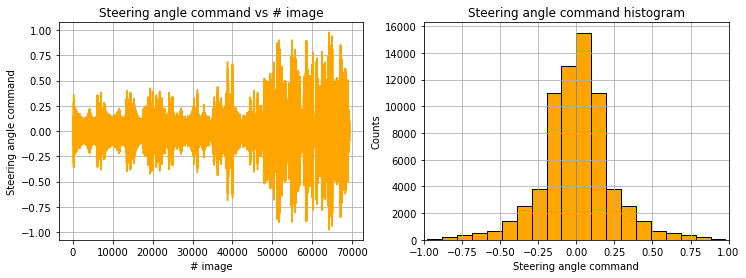

In [23]:
plot_steering_command(y_train, xlim=(-1,1), name='steer_command_hist_data_proc_aug.png')

Approximately first 2 laps were collected over 2500 images.
The histogram below presents left skewed distribution representing the bias in steering angle due to the fact that the lake laps were driven in counter-clock wise direction

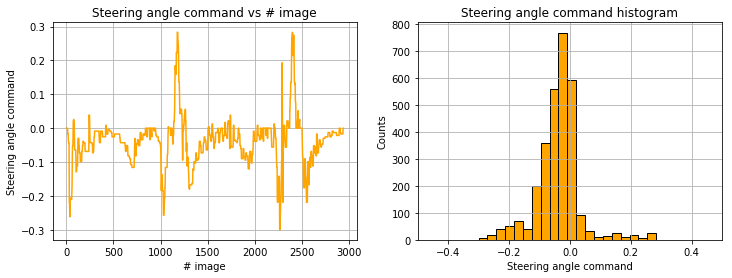

In [10]:
plot_steering_command(y_train[0:2941], xlim=(-0.5,0.5), name='steer_command_hist_2_laps.png')

All data collected on the first track (including recovery and smooth driving through curves)

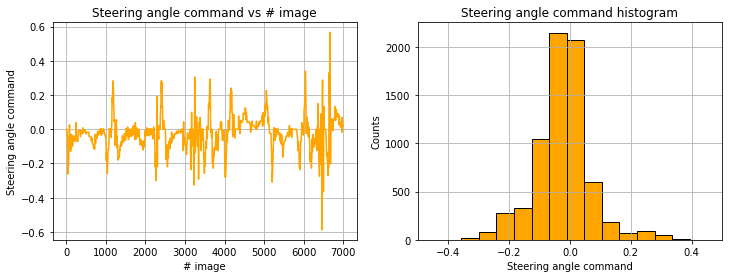

In [16]:
plot_steering_command(y_train[0:7000], xlim=(-0.5,0.5), name='steer_command_hist_track_1.png')

Second track (jungle) driving

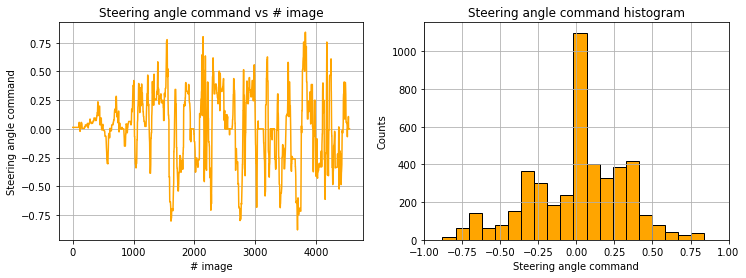

In [17]:
plot_steering_command(y_train[7000:], xlim=(-1,1), name='steer_command_hist_track_2.png')

All images combined creates dataset with the folowing symmetric distribution. A nice symmetric distribution

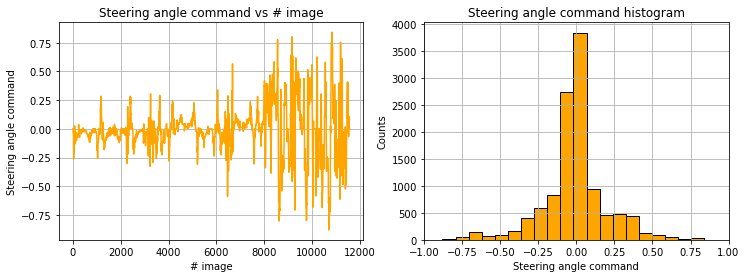

In [18]:
plot_steering_command(y_train, xlim=(-1,1))

## LeNet CNN function

In [2]:
def LeNet_nn():
    """
    LeNet neural network
    """
    model = Sequential()
    
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Conv2D(6, (5,5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(6, (5,5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [16]:
# Save LeNet neural network model
model = LeNet_nn()

# Prints a string summary of the network 
print(model.summary())

# Callbacks Stop training when a monitored quantity has stopped improving.
# This function will be passed to the .fit() method of the Sequential class.  
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model for a fixed number of epochs
history_object = model.fit(X_train, y_train, batch_size=64, epochs=30, 
                           validation_split=0.2, shuffle=True,
                           callbacks=[early_stop], verbose=1)

# Save the model to a single HDF5 file
model.save('./models/model_LeNet.h5')





Instructions for updating:
keep_dims is deprecated, use keepdims instead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 316, 6)        456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 158, 6)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 154, 6)        906       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 77, 6)         0         
________________________________________________________________

dict_keys(['val_loss', 'loss'])


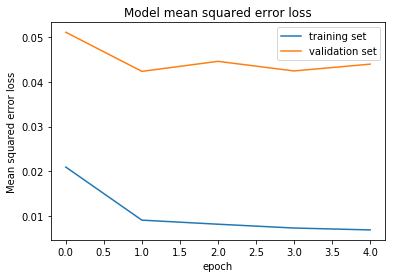

In [17]:
# Print the keys contained in the history object
print(history_object.history.keys())

# Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'], label='training set')
plt.plot(history_object.history['val_loss'], label='validation set')
plt.title('Model mean squared error loss')
plt.ylabel('Mean squared error loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.savefig('./img/Loss_LeNet_cam_With_flip.png', dpi=100)
plt.show()

## Nvidia CNN function

In [2]:
def nvidia_nn(dropout=0.0):
    """
    Nvidia convolutional neural network
    Ref: http://images.nvidia.com/content/tegra/automotive/images/2016/
    solutions/pdf/end-to-end-dl-using-px.pdf
    :dropout: float between 0 and 1. Fraction of the input units to drop.
    """
    # Sequential model - linear stack of layers
    model = Sequential()
    
    # Lambda layer: Preprocessing images - 1. Normalizing, 2. Mean centering
    # Input image shape: 160x320px, 3 color channels (RGB) 
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    
    # Cropping layer: Crops images (top, bottom) = (70, 25)
    model.add(Cropping2D(cropping=((70,25), (0,0))))
    
    # 1. Convolutional Layer
    # number of filters (out. space dim.) = 24, filter window size = 5x5
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
    
    # 2. Convolutional layer
    # number of filters (out. space dim.) = 36, filter window size = 5x5
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu"))
    
    # 3. Convolutional layer
    # number of filters (out. space dim.) = 48, filter window size = 5x5
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu"))
    
    # 4. Convolutional layer
    # number of filters (out. space dim.) = 64, filter window size = 3x3
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu"))

    # 5. Convolutional layer
    # number of filters (out. space dim.) = 64, filter window size = 3x3
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu"))

    # Flatten layer: Flattens the input
    model.add(Flatten())
    
    # Dense (fully connected) Layers, output = 1 (steering angle)
    model.add(Dense(100))
    # Dropout layer to prevent overfitting
    model.add(Dropout(rate=dropout))
    model.add(Dense(50))
    # Dropout layer to prevent overfitting
    model.add(Dropout(rate=dropout))
    model.add(Dense(10))
    model.add(Dense(1))

    # Configure the learning process
    # Optimizer = adam, loss function = mse (mean square error)
    model.compile(optimizer='adam', loss='mse')

    return model

I first tried to run 30 epochs a looked on the training and validation loss plots. It seemed that after 5 epochs the loss doesn't improved anymore and started to oscillate. 

Therefore I then implemented EarlyStopping callback function to automatically stop the training when no improvements happen after 3 epochs 

In [15]:
# Save Nvidia neural network model
model = nvidia_nn(dropout=0.35)

# Prints a string summary of the network 
print(model.summary())

# Callbacks Stop training when a monitored quantity has stopped improving.
# This function will be passed to the .fit() method of the Sequential class.  
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model for a fixed number of epochs
history_object = model.fit(X_train, y_train, batch_size=64, epochs=30, 
                           validation_split=0.2, shuffle=True,
                           callbacks=[early_stop], verbose=1)

# Save the model to a single HDF5 file
model.save('./models/model_nvidia.h5')





Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D

dict_keys(['val_loss', 'loss'])


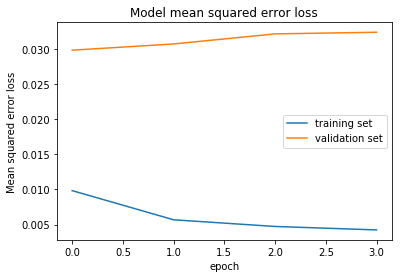

In [16]:
# Print the keys contained in the history object
print(history_object.history.keys())

# Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'], label='training set')
plt.plot(history_object.history['val_loss'], label='validation set')
plt.title('Model mean squared error loss')
plt.ylabel('Mean squared error loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.savefig('./img/Loss_Nvidia_cam_With_flip.png', dpi=100)

plt.show()

## Generators

The images captured in the car simulator are much larger than the images encountered in the Traffic Sign Classifier Project, a size of 160 x 320 x 3 compared to 32 x 32 x 3. Storing 10,000 traffic sign images would take about 30 MB but storing 10,000 simulator images would take over 1.5 GB. That's a lot of memory! Not to mention that preprocessing data can change data types from an int to a float, which can increase the size of the data by a factor of 4.

Generators can be a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.

A generator is like a coroutine, a process that can run separately from another main routine, which makes it a useful Python function. Instead of using return, the generator uses yield, which still returns the desired output values but saves the current values of all the generator's variables. When the generator is called a second time it re-starts right after the yield statement, with all its variables set to the same values as before.

**Memory Efficient**

A normal function to return a sequence will create the entire sequence in memory before returning the result. This is an overkill if the number of items in the sequence is very large.

Generator implementation of such sequence is memory friendly and is preferred since it only produces one item at a time.

In [3]:
def load_img_paths(log_file):
    samples = []
    with open(log_file) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
    return samples


In [4]:
img_path = './driving_data/driving_log.csv'
samples = load_img_paths(img_path)

# Split images into random train and test subsets
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Number of images: {}'.format(len(samples)))
print('Number of training samples: {}'.format(len(train_samples)))
print('Number of test samples: {}'.format(len(validation_samples)))

Number of images: 11555
Number of training samples: 9244
Number of test samples: 2311


In [5]:
def generator(samples, fliped=False, all_cameras=False, correction=0.1, batch_size=32):
    """ 
    Define generator to load image data
    :batch_size: Number of input images to yield at once
                 Note that # output images will depend on fliped and
                 all_cameras flags
    """
    num_samples = len(samples)
    # Loop forever so the generator never terminates
    while 1:
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images          = []
            steering_angles = []
            
            for batch_sample in batch_samples:
            
                steering_center = float(batch_sample[3])
                # create adjusted steering measurements for the side camera images
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                
                ## read in and preprocess images from center camera
                img_center = cv2.imread(batch_sample[0])                
                img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
                images.append(img_center)
                steering_angles.append(steering_center)
                #horizontal flip
                if fliped:
                    images.append(cv2.flip(img_center,1))
                    steering_angles.append(-steering_center)

                if all_cameras:
                    ## read in and preprocess images from left camera
                    img_left = cv2.imread(batch_sample[1])
                    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
                    images.append(img_left)
                    steering_angles.append(steering_left)
                    ## read in and preprocess images from right camera
                    img_right = cv2.imread(batch_sample[2])
                    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
                    images.append(img_right)
                    steering_angles.append(steering_right)

                    if fliped:
                        #horizontal flip - left image
                        images.append(cv2.flip(img_left,1))
                        steering_angles.append(-steering_left)
                        #horizontal flip - right image
                        images.append(cv2.flip(img_right,1))
                        steering_angles.append(-steering_right)    
                    
            X_features = np.array(images)
            y_labels = np.array(steering_angles)

            yield sklearn.utils.shuffle(X_features, y_labels)

## Early Stopping and Checkpoints
Source: 
- https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [6]:
# Set batch size
batch_size = 64

train_generator      = generator(train_samples, fliped=True, all_cameras=True, 
                                 correction=0.1, batch_size=batch_size)
validation_generator = generator(validation_samples, fliped=True, all_cameras=True, 
                                 correction=0.1, batch_size=batch_size)

# Save Nvidia neural network model
model = nvidia_nn(dropout=0.35)

# Prints a string summary of the network 
# print(model.summary())

# Callbacks function EarlyStopping stops training when a monitored quantity has stopped improving.
# This function will be passed to the .fit_generator() method of the Sequential class.  
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3)
# Save the best model after every epoch 
model_ckp = ModelCheckpoint('./models/best_model.h5', monitor='val_loss', 
                            verbose=1, save_best_only=True)

# Train the model for a fixed number of epochs
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=np.ceil(len(train_samples)/batch_size), 
                                     validation_data=validation_generator, 
                                     validation_steps=np.ceil(len(validation_samples)/batch_size), 
                                     epochs=30,
                                     callbacks=[early_stop, model_ckp],
                                     verbose=1)

# Save the model to a single HDF5 file
model.save('./models/model.h5')




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Epoch 1/30
145/145 [==============================] - 94s 650ms/step - loss: 0.0225 - val_loss: 0.0133
Epoch 2/30
145/145 [==============================] - 92s 637ms/step - loss: 0.0129 - val_loss: 0.0106
Epoch 3/30
145/145 [==============================] - 92s 631ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 4/30
145/145 [==============================] - 92s 634ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 5/30
145/145 [==============================] - 91s 627ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 6/30
145/145 [==============================] - 91s 631ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 7/30
145/145 [==============================] - 90s 622ms/step -

Epoch 26/30
145/145 [==============================] - 86s 595ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 27/30
145/145 [==============================] - 89s 617ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 00027: early stopping


dict_keys(['loss', 'val_loss'])


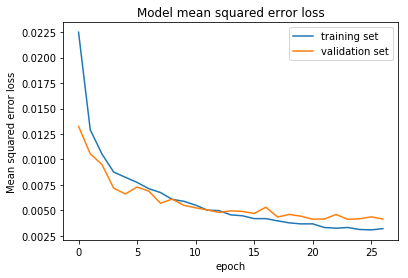

In [7]:
# Print the keys contained in the history object
print(history_object.history.keys())

# Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'], label='training set')
plt.plot(history_object.history['val_loss'], label='validation set')
plt.title('Model mean squared error loss')
plt.ylabel('Mean squared error loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.savefig('./img/Nvidia_3_cams_flip_generator.png', dpi=200, 
            bbox_inches = "tight")

plt.show()

In [8]:
exit()